<a href="https://colab.research.google.com/github/Saiharishc/Hackathon/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import time
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
#!unzip "/content/drive/My Drive/Analytics Vidhya/Train.zip" -d "/content/drive/My Drive/Analytics Vidhya/"
#!unzip "/content/drive/My Drive/Analytics Vidhya/Test.zip" -d "/content/drive/My Drive/Analytics Vidhya/"

In [4]:
train_bureau = pd.read_excel(r'/content/drive/My Drive/Analytics Vidhya/Train/train_bureau.xlsx')
train_bureau.head(2)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0


In [5]:
test_bureau = pd.read_excel(r'/content/drive/My Drive/Analytics Vidhya/Test/test_bureau.xlsx')
test_bureau.head(2)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,4,False,PRIMARY,Credit Card,CCC,2019-11-17,Individual,Active,2019-09-26,NaN,NaT,"10,000",588,NaN,589,NaN,0,0.0,NaN,"20191117,",000,"589,","0,","0,",NaN
1,4,False,PRIMARY,Housing Loan,HFC,2019-10-31,Joint,Active,2017-06-21,NaN,2019-10-15,NaN,"25,00,000","30,797/Monthly","21,07,227",F03,0,0.0,NaN,"20191031,20190930,20190831,20190731,20190630,2...",0000000000000000000000000000000000000000000000...,"2107227,2122196,2136877,2151448,2165910,218026...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,",120.0


In [ ]:
#train_bureau.isna().mean().round(3)*100

In [6]:
train_bureau['MATCH-TYPE'].value_counts()  #imbalanced so we can drop this column

PRIMARY      560647
SECONDARY       197
Name: MATCH-TYPE, dtype: int64

In [7]:
test_bureau['MATCH-TYPE'].value_counts()

PRIMARY      63991
SECONDARY       28
Name: MATCH-TYPE, dtype: int64

In [8]:
def func1(dataFrame):

      train_bureau1 = dataFrame.drop(['CREDIT-LIMIT/SANC AMT','INSTALLMENT-AMT','INSTALLMENT-FREQUENCY','MATCH-TYPE','REPORTED DATE - HIST','DPD - HIST','AMT PAID - HIST'],axis=1)
      new_df = train_bureau1['ID'].unique()
      new_df = pd.DataFrame(new_df, columns = ['ID'])

      train_bureau1['CUR BAL - HIST'] = train_bureau1['CUR BAL - HIST'].progress_apply(lambda x: np.nanmean([float(i) for i in str(x).split(',') if i]))
      train_bureau1['AMT OVERDUE - HIST'] = train_bureau1['AMT OVERDUE - HIST'].progress_apply(lambda x: np.mean([float(i) for i in str(x).split(',') if i]))
      train_bureau1['LAST-PAYMENT-DATE'] = train_bureau1['LAST-PAYMENT-DATE'].astype(str)
      train_bureau1['LAST-PAYMENT-DATE'] = train_bureau1['LAST-PAYMENT-DATE'].progress_apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%d').timetuple()) if x!='NaT' else 0)

      df_true = train_bureau1.groupby(['ID'])['SELF-INDICATOR'].value_counts().to_frame('SELF-INDICATOR_count').reset_index()
      df_true = df_true.loc[df_true['SELF-INDICATOR']==True].reset_index(drop=True)
      df_true.rename(columns={"SELF-INDICATOR_count":"SELF-INDICATOR_TRUE"},inplace=True)

      df_false = train_bureau1.groupby(['ID'])['SELF-INDICATOR'].value_counts().to_frame('SELF-INDICATOR_count').reset_index()
      df_false = df_false.loc[df_false['SELF-INDICATOR']==False].reset_index(drop=True)
      df_false.rename(columns={"SELF-INDICATOR_count":"SELF-INDICATOR_FALSE"},inplace=True)

      df_loans = train_bureau1.groupby(['ID'])['ACCT-TYPE'].count().to_frame('NumOfLoans').reset_index()

      train_bureau1['DISBURSED-AMT/HIGH CREDIT'] = train_bureau1['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '').astype(float)
      df_dis = train_bureau1.groupby('ID')['DISBURSED-AMT/HIGH CREDIT'].mean().to_frame('DISBURSED_AMT_MEAN').reset_index()

      df_tenure = train_bureau1.groupby(['ID'])['TENURE'].mean().to_frame('TENURE_AVG').reset_index()
      new_df = pd.merge(new_df,df_tenure,left_on=['ID'],how='left',right_on=['ID'])       

      new_df = pd.merge(new_df,df_dis,left_on=['ID'],how='left',right_on=['ID'])       
      new_df = pd.merge(new_df,df_true[['ID','SELF-INDICATOR_TRUE']],left_on=['ID'],how='left',right_on=['ID']) 
      new_df = pd.merge(new_df,df_false[['ID','SELF-INDICATOR_FALSE']],left_on=['ID'],how='left',right_on=['ID']) 
      new_df = pd.merge(new_df,df_loans,left_on=['ID'],how='left',right_on=['ID'])       


      for i in train_bureau1['CONTRIBUTOR-TYPE'].unique():
          df_type = train_bureau1.groupby(['ID'])['CONTRIBUTOR-TYPE'].value_counts().to_frame('CONTRIBUTOR_TYPE_'+i).reset_index()
          df_type = df_type.loc[df_type['CONTRIBUTOR-TYPE']==i].reset_index(drop=True)      
          new_df = pd.merge(new_df,df_type[['ID','CONTRIBUTOR_TYPE_'+i]],left_on=['ID'],how='left',right_on=['ID']) 

      for i in train_bureau1['OWNERSHIP-IND'].unique():
          df_type = train_bureau1.groupby(['ID'])['OWNERSHIP-IND'].value_counts().to_frame('OWNERSHIP_IND_'+i).reset_index()
          df_type = df_type.loc[df_type['OWNERSHIP-IND']==i].reset_index(drop=True)      
          new_df = pd.merge(new_df,df_type[['ID','OWNERSHIP_IND_'+i]],left_on=['ID'],how='left',right_on=['ID']) 

      for i in train_bureau1['ACCOUNT-STATUS'].unique():
          df_type = train_bureau1.groupby(['ID'])['ACCOUNT-STATUS'].value_counts().to_frame('ACCOUNT_STATUS_'+i).reset_index()
          df_type = df_type.loc[df_type['ACCOUNT-STATUS']==i].reset_index(drop=True)      
          new_df = pd.merge(new_df,df_type[['ID','ACCOUNT_STATUS_'+i]],left_on=['ID'],how='left',right_on=['ID']) 

      train_bureau1['ASSET_CLASS'] = train_bureau1['ASSET_CLASS'].replace([np.nan,'1','01','2'],'other')
      for i in train_bureau1['ASSET_CLASS'].unique():
          df_type = train_bureau1.groupby(['ID'])['ASSET_CLASS'].value_counts().to_frame('ASSET_CLASS_'+i).reset_index()
          df_type = df_type.loc[df_type['ASSET_CLASS']==i].reset_index(drop=True)      
          new_df = pd.merge(new_df,df_type[['ID','ASSET_CLASS_'+i]],left_on=['ID'],how='left',right_on=['ID']) 

      df_cur = train_bureau1.groupby(['ID'])['CUR BAL - HIST'].mean().to_frame('CUR_BAL_AVG').reset_index()
      new_df = pd.merge(new_df,df_cur,left_on=['ID'],how='left',right_on=['ID'])       
      df_ovr = train_bureau1.groupby(['ID'])['AMT OVERDUE - HIST'].mean().to_frame('OVERDUE_AVG').reset_index()
      new_df = pd.merge(new_df,df_ovr,left_on=['ID'],how='left',right_on=['ID'])    
      df_last_date = train_bureau1.groupby(['ID'])['LAST-PAYMENT-DATE'].mean().to_frame('LAST_PAYMENT_DATE').reset_index()
      new_df = pd.merge(new_df,df_last_date,left_on=['ID'],how='left',right_on=['ID'])      

      new_df= new_df.replace([np.nan],0)

      return new_df


In [9]:
train_bureau_new = func1(train_bureau)
train_bureau_new.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,ID,TENURE_AVG,DISBURSED_AMT_MEAN,SELF-INDICATOR_TRUE,SELF-INDICATOR_FALSE,NumOfLoans,CONTRIBUTOR_TYPE_NAB,CONTRIBUTOR_TYPE_NBF,CONTRIBUTOR_TYPE_PRB,CONTRIBUTOR_TYPE_CCC,CONTRIBUTOR_TYPE_COP,CONTRIBUTOR_TYPE_RRB,CONTRIBUTOR_TYPE_HFC,CONTRIBUTOR_TYPE_MFI,CONTRIBUTOR_TYPE_FRB,CONTRIBUTOR_TYPE_SFB,CONTRIBUTOR_TYPE_ARC,CONTRIBUTOR_TYPE_OFI,OWNERSHIP_IND_Individual,OWNERSHIP_IND_Guarantor,OWNERSHIP_IND_Joint,OWNERSHIP_IND_Primary,OWNERSHIP_IND_Supl Card Holder,ACCOUNT_STATUS_Delinquent,ACCOUNT_STATUS_Active,ACCOUNT_STATUS_Closed,ACCOUNT_STATUS_SUIT FILED (WILFUL DEFAULT),ACCOUNT_STATUS_Written Off,ACCOUNT_STATUS_Suit Filed,ACCOUNT_STATUS_Restructured,ACCOUNT_STATUS_Settled,ACCOUNT_STATUS_WILFUL DEFAULT,ACCOUNT_STATUS_Cancelled,ACCOUNT_STATUS_Sold/Purchased,ASSET_CLASS_Standard,ASSET_CLASS_other,ASSET_CLASS_Special Mention Account,ASSET_CLASS_SubStandard,ASSET_CLASS_Doubtful,ASSET_CLASS_Loss,CUR_BAL_AVG,OVERDUE_AVG,LAST_PAYMENT_DATE
0,1,60.000000,2.445947e+05,5.0,4.0,9,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,1.333202e+05,6002.371429,5.191968e+08
1,2,80.714286,1.393622e+06,1.0,12.0,13,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,1.115134e+06,158.217172,1.420655e+09
2,3,56.750000,1.196248e+05,2.0,29.0,31,1.0,11.0,13.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1.0,4.0,0.0,0.0,1.0,11.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.0,0.0,0.0,0.0,0.0,1.715512e+05,2022.521817,7.020446e+08
3,7,16.500000,3.181382e+05,2.0,2.0,4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.810307e+05,0.000000,3.944376e+08
4,8,39.333333,2.893166e+05,1.0,6.0,7,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,2.471944e+05,2960.151930,4.484654e+08


In [10]:
test_bureau_new = func1(test_bureau)
test_bureau_new.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,ID,TENURE_AVG,DISBURSED_AMT_MEAN,SELF-INDICATOR_TRUE,SELF-INDICATOR_FALSE,NumOfLoans,CONTRIBUTOR_TYPE_CCC,CONTRIBUTOR_TYPE_HFC,CONTRIBUTOR_TYPE_NBF,CONTRIBUTOR_TYPE_PRB,CONTRIBUTOR_TYPE_MFI,CONTRIBUTOR_TYPE_NAB,CONTRIBUTOR_TYPE_FRB,CONTRIBUTOR_TYPE_COP,CONTRIBUTOR_TYPE_RRB,CONTRIBUTOR_TYPE_SFB,CONTRIBUTOR_TYPE_OFI,OWNERSHIP_IND_Individual,OWNERSHIP_IND_Joint,OWNERSHIP_IND_Guarantor,OWNERSHIP_IND_Primary,OWNERSHIP_IND_Supl Card Holder,ACCOUNT_STATUS_Active,ACCOUNT_STATUS_Closed,ACCOUNT_STATUS_Delinquent,ACCOUNT_STATUS_Settled,ACCOUNT_STATUS_Written Off,ACCOUNT_STATUS_Suit Filed,ACCOUNT_STATUS_SUIT FILED (WILFUL DEFAULT),ACCOUNT_STATUS_Restructured,ACCOUNT_STATUS_WILFUL DEFAULT,ASSET_CLASS_other,ASSET_CLASS_Standard,ASSET_CLASS_SubStandard,ASSET_CLASS_Doubtful,ASSET_CLASS_Special Mention Account,ASSET_CLASS_Loss,CUR_BAL_AVG,OVERDUE_AVG,LAST_PAYMENT_DATE
0,4,120.000000,741147.000000,1.0,3.0,4,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,641864.840640,651.864532,7.855488e+08
1,5,180.000000,242476.625000,1.0,7.0,8,0.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,211590.023324,789.747186,1.332310e+09
2,6,24.142857,269780.083333,2.0,10.0,12,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,132244.600905,3729.941081,0.000000e+00
3,25,0.000000,400000.000000,1.0,1.0,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,163930.644118,0.000000,7.840368e+08
4,119,46.000000,465000.000000,1.0,1.0,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,253020.115873,317.600000,7.863696e+08


SELF_INDICATOR = groupby \
ACCT-TYPE = groupby & add new feature \
CONTRIBUTOR-TYPE = groupby \
OWNERSHIP-IND = groupby \
ACCOUNT-STATUS = groupby

DATE-REPORTED = it just tells when info is reported - so drop \
CLOSE-DT - unix timestamp -for nan 0 \
LAST-PAYMENT-DATE \
DISBURSED-AMT/HIGH CREDIT	- mean \
ASSET_CLASS = group by \
Tenure = mean



In [11]:
train_data = pd.read_excel(r'/content/drive/My Drive/Analytics Vidhya/Train/train_Data.xlsx')
test_data = pd.read_excel(r'/content/drive/My Drive/Analytics Vidhya/Test/test_Data.xlsx')

In [12]:
test_data.head(5)

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE
0,4,Monthly,Advance,Closed,PDC_E,2,GUNA,46,480000,365000.0,365000.0,1000.0,2011-12-29,2015-10-05,2011-12-29,3524747,1046.0,22354,75.83,M,50.0,32069.00,GUNA,MADHYA PRADESH,473001.0
1,5,Monthly,Advance,Closed,PDC,2,GUNA,45,480000,285000.0,285000.0,9300.0,2012-04-28,2016-01-01,2012-04-28,4985862,1046.0,22354,57.44,M,35.0,25000.00,GUNA,MADHYA PRADESH,473001.0
2,6,Quatrly,Arrear,Closed,PDC,2,GUNA,48,580000,400000.0,400000.0,35800.0,2013-10-22,2017-09-10,2013-10-22,12881783,1060.0,65929,68.97,M,37.0,23333.33,GUNA,MADHYA PRADESH,473001.0
3,25,Half Yearly,Arrear,Closed,Billed,154,NaN,36,725000,500000.0,500000.0,52000.0,2013-05-21,2016-02-10,2013-05-21,10613776,1049.0,68597,61.79,M,55.0,91666.67,MAHASAMUND,CHATTISGARH,493558.0
4,119,Quatrly,Arrear,Closed,PDC,194,CUTTACK,48,617000,400000.0,400000.0,35400.0,2012-11-30,2016-12-05,2012-11-30,7911110,1049.0,38493,59.09,M,48.0,12500.00,JAGATSINGHAPUR,ORISSA,754137.0


Frequency,InstlmentMode,LoanStatus,PaymentMode - onehot

AssetID,CIty,Area - drop \
ManufacturerID - freq \
SupplierID - freq \
BranchID - freq \
State - freq \
Zipcode - freq \

In [13]:
def func2(train_data1):
    #since BranchID is categorical and having repeated columns.I tried to get frequency instead of creating multiple cols
    #df['Date'] = pd.to_datetime(df['DisbursalDate'],format="%m/%d/%Y")
    train_data1['Year'] = train_data1['DisbursalDate'].dt.year
    train_data1['Month'] = train_data1['DisbursalDate'].dt.month

    
    train_data1['BranchID'] = train_data1['BranchID'].map((train_data1['BranchID'].value_counts()/len(train_data1['BranchID'])).round(5)*1000)
    train_data1['ManufacturerID'] = train_data1['ManufacturerID'].map((train_data1['ManufacturerID'].value_counts()/len(train_data1['ManufacturerID'])).round(5)*100)
    train_data1['SupplierID'] = train_data1['SupplierID'].map((train_data1['SupplierID'].value_counts()/len(train_data1['SupplierID'])).round(5)*10000)
    train_data1['State'] = train_data1['State'].map((train_data1['State'].value_counts()/len(train_data1['State'])).round(5)*1000)
    train_data1['ZiPCODE'] =train_data1['ZiPCODE'].map((train_data1['ZiPCODE'].value_counts()/len(train_data1['ZiPCODE'])).round(5)*100000)

    dummies = pd.get_dummies(train_data1[['Frequency','InstlmentMode','LoanStatus','PaymentMode','SEX']], drop_first=True)
    train_data1 = pd.concat([train_data1.drop(['Frequency','InstlmentMode','LoanStatus','PaymentMode','SEX'],axis=1), dummies],axis=1)  

    train_data1['MaturityDAte'] = train_data1['MaturityDAte'].astype(str)
    train_data1['MaturityDAte'] = train_data1['MaturityDAte'].progress_apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%d').timetuple()) if x!='NaT' else 0)

    train_data1['DisbursalDate'] = train_data1['DisbursalDate'].astype(str)
    train_data1['DisbursalDate'] = train_data1['DisbursalDate'].progress_apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%d').timetuple()) if x!='NaT' else 0)

    train_data1 = train_data1.drop(['AssetID','City','Area','AuthDate'],axis=1)
    return train_data1 

In [14]:
train_data_new = func2(train_data)
train_data_new.head()

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,State,ZiPCODE,Top-up Month,Year,Month,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,PaymentMode_Billed,PaymentMode_Cheque,PaymentMode_Direct Debit,PaymentMode_ECS,PaymentMode_ECS Reject,PaymentMode_Escrow,PaymentMode_PDC,PaymentMode_PDC Reject,PaymentMode_PDC_E,PaymentMode_SI Reject,SEX_M
0,1,4.83,48,450000,275000.0,275000.0,24000.0,1.328832e+09,1.452816e+09,12.685,4.4,61.11,49.0,35833.33,148.63,34.0,> 48 Months,2012,2,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1
1,2,4.73,47,485000,350000.0,350000.0,10500.0,1.333152e+09,1.455494e+09,14.557,4.5,70.00,23.0,666.67,148.63,97.0,No Top-up Service,2012,3,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,3,4.83,68,690000,519728.0,519728.0,38300.0,1.497658e+09,1.675987e+09,12.282,0.5,69.77,39.0,45257.00,148.63,18.0,12-18 Months,2017,6,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1
3,7,5.04,48,480000,400000.0,400000.0,11600.0,1.385683e+09,1.510272e+09,12.282,13.1,80.92,24.0,20833.33,148.63,92.0,> 48 Months,2013,11,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1
4,8,7.23,44,619265,440000.0,440000.0,15000.0,1.323302e+09,1.436054e+09,19.668,3.5,71.05,56.0,27313.67,42.35,5.0,36-48 Months,2011,12,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1


In [15]:
test_data_new = func2(test_data)
test_data_new.head()

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,State,ZiPCODE,Year,Month,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,PaymentMode_Billed,PaymentMode_Cheque,PaymentMode_Direct Debit,PaymentMode_ECS,PaymentMode_ECS Reject,PaymentMode_PDC,PaymentMode_PDC Reject,PaymentMode_PDC_E,PaymentMode_SI Reject,SEX_M
0,4,15.94,46,480000,365000.0,365000.0,1000.0,1.325117e+09,1.444003e+09,20.936,9.5,75.83,50.0,32069.00,228.76,319.0,2011,12,1,0,0,1,0,0,0,0,0,0,0,1,0,1
1,5,15.94,45,480000,285000.0,285000.0,9300.0,1.335571e+09,1.451606e+09,20.936,9.5,57.44,35.0,25000.00,228.76,319.0,2012,4,1,0,0,1,0,0,0,0,0,1,0,0,0,1
2,6,15.94,48,580000,400000.0,400000.0,35800.0,1.382400e+09,1.505002e+09,10.397,9.5,68.97,37.0,23333.33,228.76,319.0,2013,10,0,1,1,1,0,0,0,0,0,1,0,0,0,1
3,25,4.00,36,725000,500000.0,500000.0,52000.0,1.369094e+09,1.455062e+09,23.900,40.7,61.79,55.0,91666.67,15.67,75.0,2013,5,0,0,1,1,1,0,0,0,0,0,0,0,0,1
4,119,2.31,48,617000,400000.0,400000.0,35400.0,1.354234e+09,1.480896e+09,23.900,12.9,59.09,48.0,12500.00,25.43,7.0,2012,11,0,1,1,1,0,0,0,0,0,1,0,0,0,1


In [60]:
train_merge = pd.merge(train_data_new,train_bureau_new,left_on=['ID'],how='left',right_on=['ID'])  
train_merge.head()

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,State,ZiPCODE,Top-up Month,Year,Month,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,PaymentMode_Billed,PaymentMode_Cheque,PaymentMode_Direct Debit,PaymentMode_ECS,PaymentMode_ECS Reject,PaymentMode_Escrow,PaymentMode_PDC,PaymentMode_PDC Reject,PaymentMode_PDC_E,PaymentMode_SI Reject,SEX_M,TENURE_AVG,DISBURSED_AMT_MEAN,SELF-INDICATOR_TRUE,SELF-INDICATOR_FALSE,NumOfLoans,CONTRIBUTOR_TYPE_NAB,CONTRIBUTOR_TYPE_NBF,CONTRIBUTOR_TYPE_PRB,CONTRIBUTOR_TYPE_CCC,CONTRIBUTOR_TYPE_COP,CONTRIBUTOR_TYPE_RRB,CONTRIBUTOR_TYPE_HFC,CONTRIBUTOR_TYPE_MFI,CONTRIBUTOR_TYPE_FRB,CONTRIBUTOR_TYPE_SFB,CONTRIBUTOR_TYPE_ARC,CONTRIBUTOR_TYPE_OFI,OWNERSHIP_IND_Individual,OWNERSHIP_IND_Guarantor,OWNERSHIP_IND_Joint,OWNERSHIP_IND_Primary,OWNERSHIP_IND_Supl Card Holder,ACCOUNT_STATUS_Delinquent,ACCOUNT_STATUS_Active,ACCOUNT_STATUS_Closed,ACCOUNT_STATUS_SUIT FILED (WILFUL DEFAULT),ACCOUNT_STATUS_Written Off,ACCOUNT_STATUS_Suit Filed,ACCOUNT_STATUS_Restructured,ACCOUNT_STATUS_Settled,ACCOUNT_STATUS_WILFUL DEFAULT,ACCOUNT_STATUS_Cancelled,ACCOUNT_STATUS_Sold/Purchased,ASSET_CLASS_Standard,ASSET_CLASS_other,ASSET_CLASS_Special Mention Account,ASSET_CLASS_SubStandard,ASSET_CLASS_Doubtful,ASSET_CLASS_Loss,CUR_BAL_AVG,OVERDUE_AVG,LAST_PAYMENT_DATE
0,1,4.83,48,450000,275000.0,275000.0,24000.0,1.328832e+09,1.452816e+09,12.685,4.4,61.11,49.0,35833.33,148.63,34.0,> 48 Months,2012,2,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,60.000000,2.445947e+05,5.0,4.0,9,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,1.333202e+05,6002.371429,5.191968e+08
1,2,4.73,47,485000,350000.0,350000.0,10500.0,1.333152e+09,1.455494e+09,14.557,4.5,70.00,23.0,666.67,148.63,97.0,No Top-up Service,2012,3,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,80.714286,1.393622e+06,1.0,12.0,13,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,1.115134e+06,158.217172,1.420655e+09
2,3,4.83,68,690000,519728.0,519728.0,38300.0,1.497658e+09,1.675987e+09,12.282,0.5,69.77,39.0,45257.00,148.63,18.0,12-18 Months,2017,6,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,56.750000,1.196248e+05,2.0,29.0,31,1.0,11.0,13.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1.0,4.0,0.0,0.0,1.0,11.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.0,0.0,0.0,0.0,0.0,1.715512e+05,2022.521817,7.020446e+08
3,7,5.04,48,480000,400000.0,400000.0,11600.0,1.385683e+09,1.510272e+09,12.282,13.1,80.92,24.0,20833.33,148.63,92.0,> 48 Months,2013,11,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,16.500000,3.181382e+05,2.0,2.0,4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.810307e+05,0.000000,3.944376e+08
4,8,7.23,44,619265,440000.0,440000.0,15000.0,1.323302e+09,1.436054e+09,19.668,3.5,71.05,56.0,27313.67,42.35,5.0,36-48 Months,2011,12,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,39.333333,2.893166e+05,1.0,6.0,7,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,2.471944e+05,2960.151930,4.484654e+08


In [61]:
test_merge = pd.merge(test_data_new,test_bureau_new,left_on=['ID'],how='left',right_on=['ID'])  
ID = test_merge['ID']
test_merge.head(5)

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,State,ZiPCODE,Year,Month,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,PaymentMode_Billed,PaymentMode_Cheque,PaymentMode_Direct Debit,PaymentMode_ECS,PaymentMode_ECS Reject,PaymentMode_PDC,PaymentMode_PDC Reject,PaymentMode_PDC_E,PaymentMode_SI Reject,SEX_M,TENURE_AVG,DISBURSED_AMT_MEAN,SELF-INDICATOR_TRUE,SELF-INDICATOR_FALSE,NumOfLoans,CONTRIBUTOR_TYPE_CCC,CONTRIBUTOR_TYPE_HFC,CONTRIBUTOR_TYPE_NBF,CONTRIBUTOR_TYPE_PRB,CONTRIBUTOR_TYPE_MFI,CONTRIBUTOR_TYPE_NAB,CONTRIBUTOR_TYPE_FRB,CONTRIBUTOR_TYPE_COP,CONTRIBUTOR_TYPE_RRB,CONTRIBUTOR_TYPE_SFB,CONTRIBUTOR_TYPE_OFI,OWNERSHIP_IND_Individual,OWNERSHIP_IND_Joint,OWNERSHIP_IND_Guarantor,OWNERSHIP_IND_Primary,OWNERSHIP_IND_Supl Card Holder,ACCOUNT_STATUS_Active,ACCOUNT_STATUS_Closed,ACCOUNT_STATUS_Delinquent,ACCOUNT_STATUS_Settled,ACCOUNT_STATUS_Written Off,ACCOUNT_STATUS_Suit Filed,ACCOUNT_STATUS_SUIT FILED (WILFUL DEFAULT),ACCOUNT_STATUS_Restructured,ACCOUNT_STATUS_WILFUL DEFAULT,ASSET_CLASS_other,ASSET_CLASS_Standard,ASSET_CLASS_SubStandard,ASSET_CLASS_Doubtful,ASSET_CLASS_Special Mention Account,ASSET_CLASS_Loss,CUR_BAL_AVG,OVERDUE_AVG,LAST_PAYMENT_DATE
0,4,15.94,46,480000,365000.0,365000.0,1000.0,1.325117e+09,1.444003e+09,20.936,9.5,75.83,50.0,32069.00,228.76,319.0,2011,12,1,0,0,1,0,0,0,0,0,0,0,1,0,1,120.000000,741147.000000,1.0,3.0,4,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,641864.840640,651.864532,7.855488e+08
1,5,15.94,45,480000,285000.0,285000.0,9300.0,1.335571e+09,1.451606e+09,20.936,9.5,57.44,35.0,25000.00,228.76,319.0,2012,4,1,0,0,1,0,0,0,0,0,1,0,0,0,1,180.000000,242476.625000,1.0,7.0,8,0.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,211590.023324,789.747186,1.332310e+09
2,6,15.94,48,580000,400000.0,400000.0,35800.0,1.382400e+09,1.505002e+09,10.397,9.5,68.97,37.0,23333.33,228.76,319.0,2013,10,0,1,1,1,0,0,0,0,0,1,0,0,0,1,24.142857,269780.083333,2.0,10.0,12,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,5.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,132244.600905,3729.941081,0.000000e+00
3,25,4.00,36,725000,500000.0,500000.0,52000.0,1.369094e+09,1.455062e+09,23.900,40.7,61.79,55.0,91666.67,15.67,75.0,2013,5,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0.000000,400000.000000,1.0,1.0,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,163930.644118,0.000000,7.840368e+08
4,119,2.31,48,617000,400000.0,400000.0,35400.0,1.354234e+09,1.480896e+09,23.900,12.9,59.09,48.0,12500.00,25.43,7.0,2012,11,0,1,1,1,0,0,0,0,0,1,0,0,0,1,46.000000,465000.000000,1.0,1.0,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,253020.115873,317.600000,7.863696e+08


In [87]:
X = train_merge.drop(['Top-up Month'],axis=1)
y = train_merge['Top-up Month']

check_null_df = X.isnull().any().to_frame().reset_index().rename(columns = {'index':'Column_name', 0:'Null_bool'})
check_null_df[check_null_df['Null_bool']==True]
X.fillna(0, inplace=True)

In [88]:
drop_temp = np.setdiff1d(list(X.columns),list(test_merge.columns))
X.drop(columns = drop_temp, inplace = True)

In [89]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [90]:
test_merge.fillna(0,inplace=True)

from sklearn.preprocessing import StandardScaler
X_train_scale = X_train
scaler = StandardScaler()
# transform data
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
test_merge_scale = scaler.transform(test_merge)

In [91]:
print(X_train.shape,' ',y_train.shape)

(86198, 71)   (86198,)


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

'''model = XGBClassifier()

clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)

y_train_pred2 = clf.predict(X_train)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = clf.predict(X_test)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))'''

"model = XGBClassifier()\n\nclf = OneVsRestClassifier(model)\nclf.fit(X_train, y_train)\n\ny_train_pred2 = clf.predict(X_train)\nprint('train_pred',f1_score(y_train,y_train_pred2, average='macro'))\n\ny_test_pred2 = clf.predict(X_test)\nprint('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))"

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from scipy import stats
params = {'estimator__learning_rate' :stats.uniform(0.001,0.1),
          'estimator__n_estimators':[100,250,500,750,1000],
          'estimator__gamma':stats.uniform(0,0.01),
          'estimator__subsample':(0.3,0.4,0.5,0.6, 0.7),
          'estimator__reg_alpha':[25,50,75,100,150],
          'estimator__reg_lambda':[25,50,75,100,150],
          'estimator__max_depth':np.arange(1,10),
          'estimator__colsample_bytree':[0.3,0.4,0.5,0.6,0.7],
          'estimator__min_child_weight':np.arange(1,10)}
base_estimator = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=5, scoring='f1_macro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train, y_train)
print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

y_train_pred2 = clf.predict(X_train)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = clf.predict(X_test)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))

In [36]:
test_merge = test_merge.reindex(X_train.columns, axis=1) 

In [ ]:
final_pred = clf.predict(test_merge)

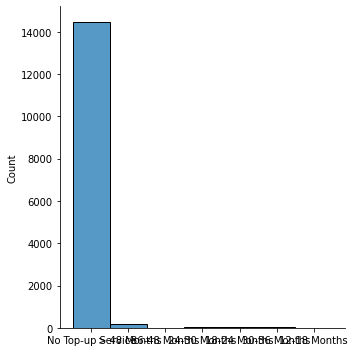

In [ ]:
my_submission = pd.DataFrame({'ID': ID, 'Top-up Month': final_pred})
sns.displot(my_submission)

In [ ]:
my_submission.to_csv('./submission.csv', sep = ',', index = False)

EMI * Tenure * Frequency = Disbursal amount + interest

000 = 0 payments past due (current account)
001 to 999 = Number days past due. If an account is above 999 days, mark as 999
XXX = No payment history available prior to this time. An “X” may not be embedded within other values.
DDD = No payment history available this month. “D” may be embedded in the payment pattern.

['000', '000', '000', '000', '000', '000', '027', '028', '028', 'DDD', '026', '030', 'DDD', '000', '000', '000', 'DDD', 'DDD', '000', 'DDD', '000', '000', '000', '000', '000', '000']
You are supposed to impute values for D and X here.

Tenure is the period of a loan in months.
Tenure/Freq = number of installments

In [ ]:
# Chintan 

In [ ]:
''''new_df = pd.DataFrame()
# self_incdicator_count_lst = []
self_incdicator_count_true_lst = [] ###
self_incdicator_count_false_lst = []    ###
for id in tqdm(df['ID'].unique()):
    try:
        true_count = df[(df['ID']==id) & (df['SELF-INDICATOR']==True)]['SELF-INDICATOR_count'].values[0]
    except:
        true_count = 0
        
    try:
        false_count = df[(df['ID']==id) & (df['SELF-INDICATOR']==False)]['SELF-INDICATOR_count'].values[0]
    except:
        false_count = 0

    self_incdicator_count_true_lst.append(true_count)   ###
    self_incdicator_count_false_lst.append(false_count) ###
    # self_incdicator_count_lst.append([true_count, false_count])

    new_df['ID'], new_df['self_indicator_true_count'], new_df['self_indicator_false_count'] = df['ID'].unique(), self_incdicator_count_true_lst, self_incdicator_count_false_lst''''

In [ ]:
#np.setdiff1d(list(X_train.columns),list(test_merge.columns))
np.setdiff1d(list(test_merge.columns),list(X_train.columns))

array([], dtype='<U42')

# **Hyper-parameter Tuning. LGBM & XGB**

In [ ]:
X = train_merge.drop(['Top-up Month'],axis=1)
y = train_merge['Top-up Month']

In [ ]:
check_null_df = X.isnull().any().to_frame().reset_index().rename(columns = {'index':'Column_name', 0:'Null_bool'})
check_null_df[check_null_df['Null_bool']==True]
X.fillna(0, inplace=True)

,Column_name,Null_bool
12,AGE,True
13,MonthlyIncome,True
15,ZiPCODE,True


In [ ]:
X.fillna(0, inplace=True)

In [ ]:
X.isna().any().sum()

0

In [ ]:
drop_temp = np.setdiff1d(list(X.columns),list(test_merge.columns))
X.drop(columns = drop_temp, inplace = True)

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [ ]:
print(X_train.shape,' ',y_train.shape)

(86198, 69)   (86198,)


In [37]:
from sklearn.preprocessing import StandardScaler
X_train_scale = X_train
scaler = StandardScaler()
# transform data
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
test_merge_scale = scaler.transform(test_merge)

In [49]:
params = {"learning_rate": uniform(0.03,0.5),
          "max_depth": randint(2,10),
          "subsample": uniform(0.2,0.8),
          "colsample_bytree": uniform(0.2,0.8),
          "n_estimators": randint(100,300)
}


xgb_model = XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           max_delta_step=0,
                                           min_child_weight=1,
                                           missing=None,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1)

rand_xgb = RandomizedSearchCV(xgb_model, param_distributions=params, cv=3, n_iter=3, scoring='f1_macro', return_train_score=True, n_jobs=-1, verbose=3)
rand_xgb.fit(X_train_scale, y_train)

y_train_pred2 = rand_xgb.predict(X_train_scale)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = rand_xgb.predict(X_test_scale)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))

final_pred = rand_xgb.predict(test_merge_scale)
my_submission = pd.DataFrame({'ID': ID, 'Top-up Month': final_pred})
my_submission.to_csv('./submission1.csv', sep = ',', index = False)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 24.4min finished


train_pred 0.4514823628172495
cv_pred 0.4152369110452171


**stacking**

In [84]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [101]:
estimators = [ ('rf',OneVsRestClassifier(RandomForestClassifier(n_estimators=150, max_depth=15,random_state=42,class_weight='balanced'))  ),
                      ('lgb',OneVsRestClassifier(lgb.LGBMClassifier(n_estimators=100, max_depth=9,random_state=42,class_weight='balanced'))  ),
                      ('nb',OneVsRestClassifier(GaussianNB(var_smoothing=1e-03)))
                       ]
final_estimator=OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1',alpha=0.001,class_weight='balanced',max_iter=100))

clf_stacked = OneVsRestClassifier(StackingClassifier(estimators=estimators, final_estimator=final_estimator,stack_method='predict_proba',passthrough=True,n_jobs=-1 ))

In [102]:
clf_stacked.fit(X_train_scale, y_train)

y_train_pred2 = clf_stacked.predict(X_train_scale)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = clf_stacked.predict(X_test_scale)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))

final_pred = clf_stacked.predict(test_merge_scale)  
my_submission = pd.DataFrame({'ID': ID, 'Top-up Month': final_pred})
my_submission.to_csv('./submission2.csv', sep = ',', index = False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train_pred 0.32313879892938113
cv_pred 0.26807898187099016


In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": randint(0,10),
    "subsample": uniform(0.2,0.8)
}
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt',                      
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None)
rand_lgbm = RandomizedSearchCV(lgb_model, param_distributions=params, cv=3, n_iter=3, scoring='f1_macro', return_train_score=True, verbose=3, n_jobs=-1)
rand_lgbm.fit(X_train_scale, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                            subsample_for_bin=200000,
                                            subsample_f

In [44]:
from sklearn.metrics import f1_score
y_train_pred2 = rand_lgbm.predict(X_train_scale)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = rand_lgbm.predict(X_test_scale)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))

train_pred 0.49386315820929955
cv_pred 0.43262052939403317


In [41]:
y_test_pred2

array(['No Top-up Service', 'No Top-up Service', 'No Top-up Service', ...,
       '18-24 Months', 'No Top-up Service', 'No Top-up Service'],
      dtype=object)

In [45]:
final_pred = rand_lgbm.predict(test_merge_scale)

In [46]:
final_pred

array(['No Top-up Service', 'No Top-up Service', 'No Top-up Service', ...,
       'No Top-up Service', 'No Top-up Service', 'No Top-up Service'],
      dtype=object)

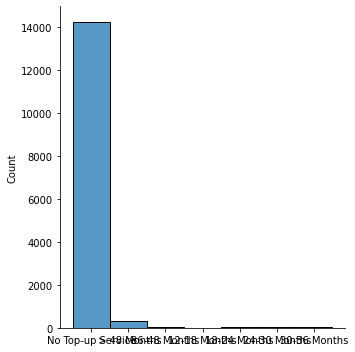

In [47]:
my_submission = pd.DataFrame({'ID': ID, 'Top-up Month': final_pred})
sns.displot(final_pred)

In [48]:
my_submission.to_csv('./submission.csv', sep = ',', index = False)

In [ ]:
# Parameters, https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
# Understanding each parameter, https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b
# -------------------------------------------------------------------
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

params = {
    "learning_rate": uniform(0.05,0.7),
    "max_depth": randint(2,10),
    "subsample": uniform(0.2,0.8),
    "colsample_bytree": uniform(0.2,0.8),
    "n_estimators": randint(80,300),
    "reg_alpha": [0.0001,0.001,0.01,0.1,1,10],
    "reg_lambda": [0.0001,0.001,0.01,0.1,1,10]
}

lgb_model = lgb.LGBMClassifier()
rand_lgbm = RandomizedSearchCV(lgb_model, param_distributions=params, cv=2, n_iter=50, scoring='f1_macro', return_train_score=True, verbose=3, n_jobs=-1)
rand_lgbm.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.7min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f91d4b847b8

In [ ]:
from sklearn.metrics import f1_score
y_train_pred2 = rand_lgbm.predict(X_train)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = rand_lgbm.predict(X_test)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))

train_pred 0.5419045295106517
cv_pred 0.41988196478991885


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
params = {"learning_rate": uniform(0.03,0.5),
          "max_depth": randint(2,10),
          "subsample": uniform(0.2,0.8),
          "colsample_bytree": uniform(0.2,0.8),
          "n_estimators": randint(100,300),
          "alpha": [0.0001,0.001,0.01,0.1,1,10,100,1000],
          "lambda": [0.0001,0.001,0.01,0.1,1,10,100,1000]
}

rand_xgb = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions=params, cv=2, n_iter=50, scoring='f1_macro', return_train_score=True, n_jobs=-1, verbose=3)
rand_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 176.4min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f91dbbc9160>,
                                        'n_estimator

In [ ]:
y_train_pred2 = rand_xgb.predict(X_train)
print('train_pred',f1_score(y_train,y_train_pred2, average='macro'))

y_test_pred2 = rand_xgb.predict(X_test)
print('cv_pred',f1_score(y_test,y_test_pred2, average='macro'))

train_pred 0.6969501286596717
cv_pred 0.4219251735619484


In [ ]:
test_merge = test_merge.reindex(X_train.columns, axis=1) 
final_pred = rand_xgb.predict(test_merge)
my_submission = pd.DataFrame({'ID': ID, 'Top-up Month': final_pred})
my_submission.to_csv('./submission.csv', sep = ',', index = False)

# **MLP Model**

In [ ]:
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as ks
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

In [ ]:
def create_simple_mlp_model(input_shape):   #input_shape=X_train.shape[1]
    model_in = Input(shape=(input_shape,))
    out = Dense(192, activation='tanh', kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = Dropout(0.10)(out)
    out = Dense(128, activation='tanh',  kernel_regularizer=regularizers.l1(0.0001))(out)
    #out = BatchNormalization()(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(7, activation='softmax')(out)
    model = Model(model_in, out)
    return model

In [ ]:
simple_model = create_simple_mlp_model(X_train.shape[1])
simple_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 192)               13440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 455       
Total params: 46,855
Trainable params: 46,855
Non-trainable params: 0
_______________________________________________________

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
# y_train = tf.one_hot(y_train, 7)
# y_test = tf.one_hot(y_test, 7)

In [ ]:
y_train

array([6, 6, 6, ..., 3, 6, 0])

In [ ]:
best_models_path = "/content/drive/My Drive/Analytics Vidhya/BEST_MODEL.hdfs"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=7)
]

In [ ]:
# sparse_categorical_crossentropy
# categorical_crossentropy
simple_model.compile(loss='sparse_categorical_crossentropy', optimizer=ks.optimizers.Adam(lr=0.0003), metrics=['accuracy'])
simple_model.fit(x=X_train, y=y_train, batch_size=192, epochs=50, verbose=True, validation_data=(X_test, y_test),
                 callbacks=callbacks_lst)

In [ ]:
def inference(model, X_test):
    predictions = []
    y_test_pred2 = model.predict(X_test)
    for pred in y_test_pred2:
        predictions.append(pred.argmax())
    
    return predictions

In [ ]:
predictions = inference(simple_model, X_test)

In [ ]:
print('cv_pred',f1_score(y_test, predictions, average='macro'))

cv_pred 0.1295152742597406


In [ ]:
test_merge = test_merge.reindex(X_train.columns, axis=1) 

In [ ]:
final_pred = inference(simple_model, test_merge)
final_pred = le.inverse_transform(final_pred)

In [ ]:
my_submission = pd.DataFrame({'ID': ID, 'Top-up Month': final_pred})
my_submission.to_csv('./submission.csv', sep = ',', index = False)